# Demystifying: Machine Learning

https://www.optica.org/events/congress/advanced_photonics_congress/program/demystifying/

Carlos Natalino $^1$ and Ben Mills $^2$

$^1$ Department of Electrical Engineering, Chalmers University of Technology, Gothenburg, Sweden. https://www.chalmers.se/en/persons/carda/

$^2$ University of Southampton, Southampton, UK. https://www.southampton.ac.uk/people/5x7lvp/doctor-ben-mills

## Part 1.3.2: Applying unsupervised for anomaly detection

General links can be found here: https://github.com/carlosnatalino/demystifying-ml/

### Step 1: setup environment, import relevant libraries and files

In [2]:
# Here we concentrate all the imports
import glob
import random
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import requests
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn import decomposition
import sklearn.metrics as skmetrics

%matplotlib inline

In [3]:
sys.version

'3.12.4 (main, Jun  6 2024, 18:26:44) [Clang 15.0.0 (clang-1500.3.9.4)]'

In [4]:
import matplotlib
matplotlib.__version__

'3.9.1'

In [5]:
pd.__version__

'2.2.2'

In [6]:
requests.__version__

'2.32.3'

In [7]:
import sklearn
sklearn.__version__

'1.5.1'

In [8]:
# check the `datasets` folder on GitHub for a complete list of the service datasets available.
service_id = 1002

In [9]:
# Here we list the files that are within the folder.
os.makedirs("./figures", exist_ok=True)
os.makedirs("./downloads", exist_ok=True)
if not os.path.exists(f"./downloads/service_{service_id}_data.csv"):
    with open(f"./downloads/service_{service_id}_data.csv", "wt", encoding="utf-8") as file:
        content = requests.get(f"https://github.com/carlosnatalino/demystifying-ml/raw/main/datasets/service_{service_id}_data.csv")
        file.write(content.text)
os.listdir("./downloads")

['service_1002_data.csv', 'nobel-eu_200_initial_dataset.csv']

In [10]:
# Setting seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

### Step 2: load the data

In [11]:
# Listing data files.
glob.glob("./downloads/service_*_data.csv")

['./downloads/service_1002_data.csv']

In [12]:
# Pick one of the service IDs shown above.
data_ad = pd.read_csv(f"./downloads/service_{service_id}_data.csv")
data_ad.describe()

,GSNR,ASE,NLI,status
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,12.424359,12.495753,30.433592,0.500000
std,0.649325,0.665375,0.519377,0.500013
min,11.205421,11.244507,29.683639,0.000000
25%,11.815239,11.871565,30.014746,0.000000
50%,12.539121,12.614530,30.354382,0.500000
75%,13.031819,13.116411,30.683544,1.000000
max,13.404702,13.508048,31.683605,1.000000


### Step 3: Visualize the data using principal component analysis

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [13]:
pca = decomposition.PCA(n_components=2)
data_ad_transf = pca.fit_transform(data_ad)
data_ad_transf.shape

(20000, 2)

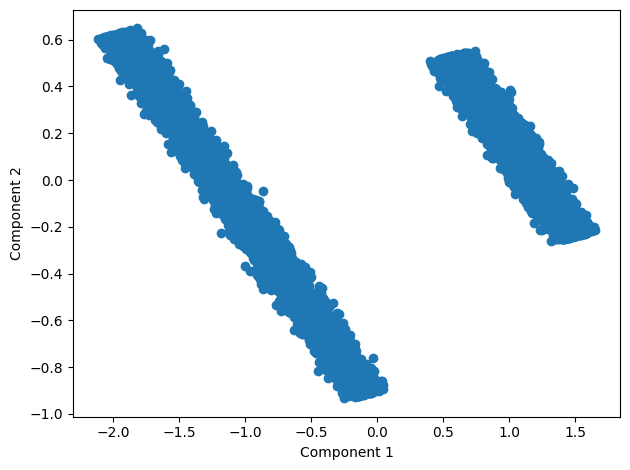

In [14]:
plt.figure()
plt.scatter(data_ad_transf[:, 0], data_ad_transf[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

### Step 4: Split dataset between normal and abnormal

In [15]:
data_normal = data_ad[(data_ad["status"]==0)].drop(["status"], axis=1)
data_normal.describe()

,GSNR,ASE,NLI
count,10000.000000,10000.000000,10000.000000
mean,13.033691,13.118565,30.187688
std,0.145059,0.153290,0.289568
min,12.666838,12.735954,29.683646
25%,12.915745,12.993071,29.938181
50%,13.031836,13.116421,30.185083
75%,13.151189,13.242934,30.441816
max,13.404702,13.508048,30.683605


In [21]:
# for semi-supervised and unsupervised learning, the scaling only considers the normal data since we should assume we don't have data about anomalies at the time of defining the model
scaler = preprocessing.StandardScaler().fit(data_normal)
data_normal_scaled = scaler.transform(data_normal)
data_normal_scaled.shape

(10000, 3)

In [17]:
data_abnormal = data_ad[(data_ad["status"]==1)].drop(["status"], axis=1)
data_abnormal.describe()
data_abnormal_scaled = scaler.transform(data_abnormal)

### Step 5: Evaluating hyperparameters

In this example, we use DBSCAN, with documentation available [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

#### Performing hyperparameter analysis

If you are curious about a more detailed example, you can find it here: https://github.com/carlosnatalino/JLT-2020-ML-Practical-Perspective/blob/master/training-ul-ssl-models.ipynb

In [31]:
# hyperparameters
samples_normal = 100
samples_abnormal = 15

epsilon_configurations = [.1, .5, 1., 2., 3., 4., 5., 10.]
min_samples_configurations = [3, 5, 8, 10, 12, 15, 20, 50, 80, 100]
best_configuration = None
highest_f1 = .0
best_model = None
print(data_normal_scaled[:samples_normal, :].shape)

(100, 3)


In [32]:
print("M\teps\tf1 score")
for min_samples in min_samples_configurations:
    for epsilon in epsilon_configurations:

        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
        x = np.concatenate((data_normal_scaled[:samples_normal, :], data_abnormal_scaled[:samples_abnormal, :]))
        y_pred = dbscan.fit_predict(x)
        normal_indices = np.where(y_pred >= 0)
        abnormal_indices = np.where(y_pred == -1)
        y_pred[normal_indices] = 0
        y_pred[abnormal_indices] = 1
        # print(y_pred)

        f1 = skmetrics.f1_score(
            np.concatenate((np.full((samples_normal,), fill_value=0), np.full((samples_abnormal,), fill_value=1))),
            y_pred
        )

        message = f"{min_samples}\t{epsilon}\t{f1:.3f}"
        if f1 > highest_f1:
            highest_f1 = f1
            best_configuration = min_samples, epsilon
            best_model = dbscan
            message += "\t* best!"
        print(message)
print("\nDone!")
print("Best configuration:", best_configuration)
print("f1 score:", highest_f1)

M	eps	f1 score
3	0.1	0.252	* best!
3	0.5	0.889	* best!
3	1.0	0.636
3	2.0	0.000
3	3.0	0.000
3	4.0	0.000
3	5.0	0.000
3	10.0	0.000
5	0.1	0.240
5	0.5	0.968	* best!
5	1.0	1.000	* best!
5	2.0	0.000
5	3.0	0.000
5	4.0	0.000
5	5.0	0.000
5	10.0	0.000
8	0.1	0.231
8	0.5	0.882
8	1.0	1.000
8	2.0	1.000
8	3.0	0.636
8	4.0	0.000
8	5.0	0.000
8	10.0	0.000
10	0.1	0.231
10	0.5	0.857
10	1.0	1.000
10	2.0	1.000
10	3.0	1.000
10	4.0	1.000
10	5.0	0.000
10	10.0	0.000
12	0.1	0.231
12	0.5	0.667
12	1.0	1.000
12	2.0	1.000
12	3.0	1.000
12	4.0	1.000
12	5.0	0.333
12	10.0	0.000
15	0.1	0.231
15	0.5	0.395
15	1.0	1.000
15	2.0	1.000
15	3.0	1.000
15	4.0	1.000
15	5.0	1.000
15	10.0	0.000
20	0.1	0.231
20	0.5	0.286
20	1.0	0.968
20	2.0	1.000
20	3.0	1.000
20	4.0	1.000
20	5.0	1.000
20	10.0	0.000
50	0.1	0.231
50	0.5	0.231
50	1.0	0.231
50	2.0	0.968
50	3.0	1.000
50	4.0	1.000
50	5.0	1.000
50	10.0	0.000
80	0.1	0.231
80	0.5	0.231
80	1.0	0.231
80	2.0	0.231
80	3.0	1.000
80	4.0	1.000
80	5.0	1.000
80	10.0	0.000
100	0.1	0.231
100	0.5	0.231
100	

### Step 6: Visualizing the results

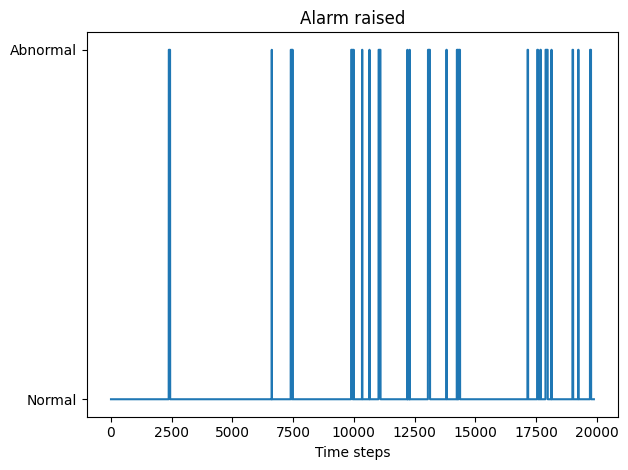

In [37]:
data_ad_scaled = scaler.transform(data_ad.drop(["status"], axis=1))

status = []

for i in range(data_ad_scaled.shape[0] - samples_normal - samples_abnormal):
    y_pred = best_model.fit_predict(data_ad_scaled[i:i+samples_normal+samples_abnormal, :])
    if np.any(y_pred == -1):
        status.append(1)
    else:
        status.append(0)

plt.figure()

plt.plot(status)
plt.title("Alarm raised")
plt.yticks([0, 1], ["Normal", "Abnormal"])
plt.xlabel("Time steps")
plt.tight_layout()
plt.show()